#### BY: Chris Kinyanjui Kamau.
#### Predictive Models for the Kong County House Sales.

# Business Understanding

I am to examine the data, as a Data Scioentist. the King County House Sales dataset to be specific, which is in the kc_house_data.csv document.I will be attempting to find the major contributors to house pricing {***USD***}  in a northwestern county.

I will be using several models of linear regression and multiple linear regresions so as to build a model to predict the price of houses..

In [1]:
# Importing the relevant libraries.

import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt

%matplotlib inline 

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error

import scipy.stats as stats

from uszipcode import SearchEngine


In [2]:
# loading the data into the dataframe kc.
# index col is set to zero to ensure the id column is used as the index.

kc = pd.read_csv('kc_house_data.csv', index_col=0)
kc.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Dataframe Exploration

In [3]:
#let us define some functions to get relevant information from the Data Frames.

#get value types of entries per column.

def get_value(data,col_name):
    
    return data[col_name].value_counts()

#get general information for the whole data frame.

def get_info(data):
    info_ = data.info()
    return info_


# Defining a function to get the percentages of missing values.
def missing_values(data):
    miss_vals = data.isnull().sum().sort_values(ascending=False)
    
    #percentages
    percentages = (((data.isnull().sum()) / len(data)).sort_values(ascending=False))*100
    
    #create dataframe of missing values
    
    missing_df = pd.DataFrame({"Total missing values": miss_vals, 'Percentage(%)':percentages})
    
    #if percentage == 0 implies no missing values
    missing_df.drop(missing_df[missing_df['Percentage(%)']==0].index, inplace = True)
    
    return missing_df

# defining a function to look for duplicates from the DataFrames.

def get_duplicate(data):
    duplicate = data.duplicated().value_counts()
    return duplicate

#define a function that returns the unique values in a column.

def get_unique(data,column):
    return data[column].unique()


#define a function that returns a list of column names with potential descrete data based of data type

def descrete(data):
    categorical_col = []
    categoricals = kc.select_dtypes("object")

    for col in categoricals:
        categorical_col.append(col)
    return categorical_col


# let us define a function that separates  categorical data from continuous data based on the above defined function.
# while looking at value counts.
def distinguish(data):
    dependent = {}
    categorical = {}
    continuous = {}
    check = descrete(data)
    
    for col in list(data.columns):
        
        if len(data[col].unique()) > 69 and col != 'price':
            continuous[col] = len(data[col].unique())
            
        elif  col == 'price':
            dependent[col] = len(data[col].unique())
            
        else:
            categorical[col] = len(data[col].unique())
            
    for x in check:
        if x in continuous:            
            continuous.pop(x)
            
    for x in check:            
        if x not in categorical:
            categorical[x] = len(data[x].unique())
        
            
            
    return categorical,continuous,dependent

# define a function which will deal with columns with multicoliearity.

def correlation(data, threshold):
    '''
    threshhold is the maximum correlation between two variables to determine 
    if there is a multicolinearity between them.
    '''
    #define an empty set, to get the unique column names
    
    correlated_cols = set()
    corr_matrix = data.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_cols.add(colname)
    return correlated_cols

In [4]:
# getting a summary or general info of the data frame

get_info(kc)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

In [5]:
# Inspecting the data types found in the dataframe kc.

kc.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [6]:
#Using the definde functions to split the data into categorical and continuous data types.

categorical,continuous,dependent = distinguish(kc)
categorical.keys()

dict_keys(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'date', 'sqft_basement'])

In [7]:
list(continuous.keys())

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

All i have done is separate the data into categorical and continuous data based on each columns uniqe value counts. I set a limit of 100 , in that all columns with a data count less than 100 are placed in a dictionary named categorical followed by checking that the column names selected by the decrete function are included ;<br>

        * bedrooms
        * bathrooms
        * floors
        * waterfront
        * view
        * condition
        * grade
        * yr_renovated
        * zipcode
        * date
        * sqft_basement
   
<br>
Where as the continuous are stored in continuous. but without looking at there scatter plots there is no way of knowing whether the continuous column names are truly continuous variables.

In [8]:
#looking for any missing values
missing_values(kc)


,Total missing values,Percentage(%)
yr_renovated,3842,17.789508
waterfront,2376,11.001528
view,63,0.291707


### 3 columns observed with missing data 


In [9]:
# checking for duplicates on the dataframe.
get_duplicate(kc)

False    21597
dtype: int64

In [10]:
# Checking the correlation the dataframe kc has with price 
# to find the independent variables with the strongest correlation using the selected continuous variable

kc[list(continuous.keys())].corrwith(kc['price']).sort_values(ascending=False)

sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
lat              0.306692
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
long             0.022036
zipcode         -0.053402
dtype: float64

### Data Understanding of the King County House Sales dataset.

It has been loaded in with pandas as kc. Short for King County.

It has 21597 rows and 20 columns.

No duplicate rows were observed.

Only 3 columns were observed with missing values;

   1. **yr_renovated**  17.7% missing

   1. **waterfront**    11.0% missing

   1. **view**          0.29% missing
    
The kc column with the strongest correlation is the **sqft_living** (*Square footage of living space in the home*)     with a correlation of **0.701917**. This shall be used for the baseline model.

The kc dataframe comprises of 3 dtypes;<br>

   1. **dtype('O')** <br>
        t means: 'O' (Python) objects. Source.<br>
   1. **dtype('float64')**<br>
        Python float values are represented as 64-bit double-precision values.<br>
   1. **dtype('int64')**<br>
        The type int64 tells us that Python is storing each value within this column as a 64 bit integer.


# Data Preparation of the King County House Sales dataset.

Only part i had to clean up is the missing value which i shall drop the rows with the missing value as they are not mor than half or even a quarter of the whole dataset.

In [11]:
# dealing with the missing values.

# since the percent of missing values is low and i may use there column
# i will drop the rows with the missing values.

kc.dropna(inplace = True)

# rechecking missing values

missing_values(kc)

,Total missing values,Percentage(%)


In [12]:
kc.shape

(15762, 20)

In [13]:
# Now let us save this cleaned version to use in tableau.
kc.to_csv('pure_kc.csv')

In [14]:
# defining a variable that holds the dataframe of the continuous independent variables

kc_cont = kc[list(continuous.keys())]
kc_cont.head()

,sqft_living,sqft_lot,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,
6414100192,2570,7242,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
2487200875,1960,5000,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,1680,8080,1680,1987,0.0,98074,47.6168,-122.045,1800,7503
7237550310,5420,101930,3890,2001,0.0,98053,47.6561,-122.005,4760,101930
1321400060,1715,6819,1715,1995,0.0,98003,47.3097,-122.327,2238,6819


The data is ready, only cleaning was done by dropping the rows with missing values. 
In the cells i will drop columns based on whether they are categorical variables or continuous
variables

# Modeling 


## Baseline Model

In [15]:
# Checking the correlation the dataframe kc has with price after dropping the rows. 
# to find the independent variables with the strongest correlation

kc_cont.corrwith(kc['price']).sort_values(ascending=False)

sqft_living      0.706189
sqft_above       0.612014
sqft_living15    0.581572
lat              0.306607
yr_renovated     0.122731
sqft_lot         0.084504
sqft_lot15       0.079402
yr_built         0.049345
long             0.021215
zipcode         -0.049502
dtype: float64

The **sqft_living** is still the column with the highest correlation with price.

In [16]:
# for the baseline lets start by definin y the dependent variable and X the independent variable.

y = kc['price']
X_baseline = kc_cont[['sqft_living']]

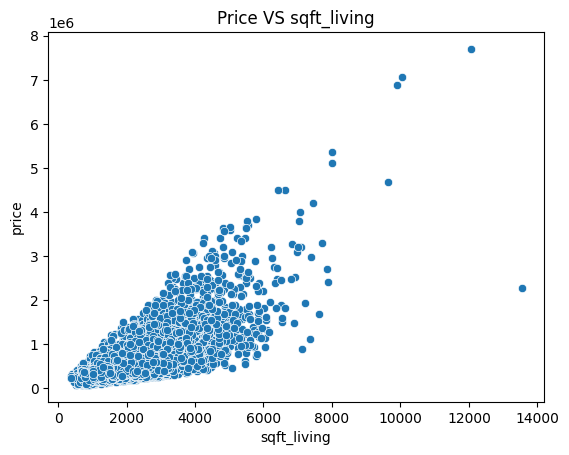

In [17]:
# Let us inspect its scatter plot to ensure it has a linear relationship with price despite dropping some columns.

sns.scatterplot(x = kc['sqft_living'],y=kc['price']).set(title='Price VS sqft_living');


The scatter plot depicts a **linear relationship**.

In [18]:
# using the Ordinary Least Method from stats model we can fit our model.

baseline_model = sm.OLS(endog=y, exog=sm.add_constant(X_baseline))
result_baseline = baseline_model.fit()

# Let us print out the summary for the model

print(result_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 1.568e+04
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:49:20   Log-Likelihood:            -2.1911e+05
No. Observations:               15762   AIC:                         4.382e+05
Df Residuals:                   15760   BIC:                         4.382e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.516e+04   5205.744    -10.597      

In [19]:
# Calculating Mean Absolute Error (mae)
mae = (result_baseline.resid.abs().sum()) / len(y)
mae

174670.90782937457

## Baseline Model Intepretation.



* Overall the model and coefficients are **statistically significant**, with all *p-values* well below a standard alpha of **0.05**.
<br>

* The **R-squared** value is about 0.499 i.e. **50%** of the variance in the target variable can be explained by sqft_living.
<br>

* The intercept is about -5.516e+04 i.e. **-55160 USD**, meaning that if one wanted a house with a square foot of living space of  0, they would expect a price of about -55160 USD.but this can be ignored as a house with 0 sqft of living room cant exist outside the mathematical realm.
<br>

* The sqft_living coefficient is about **290**, meaning that for each additional 1 USD on price of the house we have an additional  square feet of living of about 290 sqft.

* The model is off by about **175,000 USD**.

## Multilinear_1 Model 

####  Checking for multicollinearity.

despite checking with the graph, i am still in need of a more concrete reason to drop the columns as i may be biased on how the scatter may look so i will check for collinearity.

**Multicollinearity** occurs when independent variables in a regression model are correlated. This correlation is a problem because *independent variables should be independent.* If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results.

In [20]:
# define a variable to hold the dataset but only for the continuous variables.
multi = list(continuous.keys())

X_multilinear_1 = kc[multi]

In [21]:
#testsixe of 0.3 will determine the size of the sample.
# random state will ensure the samples dont vary.

X_train,X_test,y_train,y_test = train_test_split(X_multilinear_1,y, test_size=0.3,random_state=123)

In [22]:
# creating a new variable to store the Xtrain correlation matrix.
corrmatrix = X_train.corr()
corrmatrix

,sqft_living,sqft_lot,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
sqft_living,1.000000,0.153219,0.879022,0.314213,0.048921,-0.202235,0.058552,0.238587,0.754703,0.165139
sqft_lot,0.153219,1.000000,0.164911,0.052740,0.000920,-0.127558,-0.091147,0.224186,0.139534,0.704585
sqft_above,0.879022,0.164911,1.000000,0.417515,0.020642,-0.262410,0.009123,0.342737,0.732595,0.178668
yr_built,0.314213,0.052740,0.417515,1.000000,-0.222800,-0.346952,-0.144376,0.406887,0.320821,0.071206
yr_renovated,0.048921,0.000920,0.020642,-0.222800,1.000000,0.060963,0.030298,-0.062580,-0.003778,0.005174
zipcode,-0.202235,-0.127558,-0.262410,-0.346952,0.060963,1.000000,0.263746,-0.558585,-0.287866,-0.149310
lat,0.058552,-0.091147,0.009123,-0.144376,0.030298,0.263746,1.000000,-0.129600,0.051429,-0.102308
long,0.238587,0.224186,0.342737,0.406887,-0.062580,-0.558585,-0.129600,1.000000,0.340159,0.251744
sqft_living15,0.754703,0.139534,0.732595,0.320821,-0.003778,-0.287866,0.051429,0.340159,1.000000,0.184225
sqft_lot15,0.165139,0.704585,0.178668,0.071206,0.005174,-0.149310,-0.102308,0.251744,0.184225,1.000000


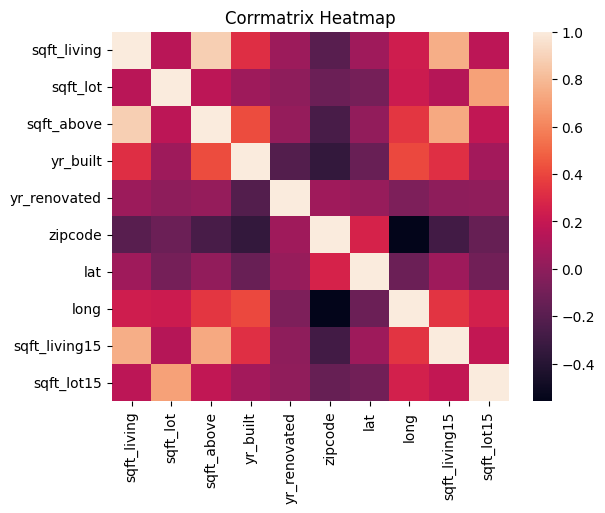

In [23]:
#visualizing the correlation matrix for easier interpretation.
sns.heatmap(corrmatrix).set(title= 'Corrmatrix Heatmap');

In [24]:
#The columns with a correlation of 0.7 or 70% are selected.

corr_feature = correlation(X_train,0.7)
corr_feature

{'sqft_above', 'sqft_living15', 'sqft_lot15'}

In [25]:
# dropping the col with a correlation threshhold of 0.7 to ensure multicolinearity doess not occur 

X_train.drop(labels = corr_feature,axis=1,inplace=True)
X_test.drop(labels = corr_feature,axis=1,inplace=True)

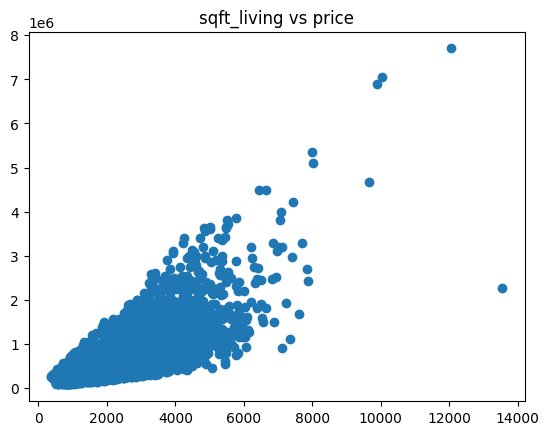

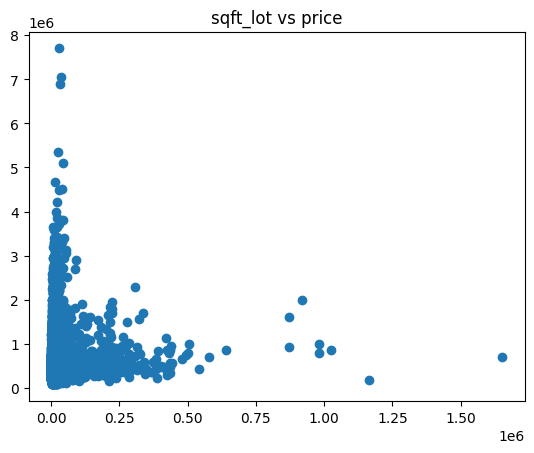

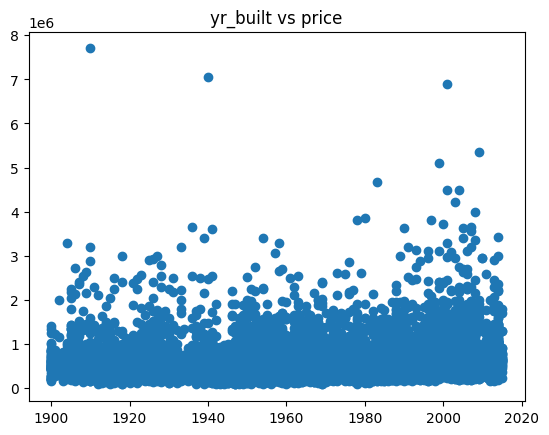

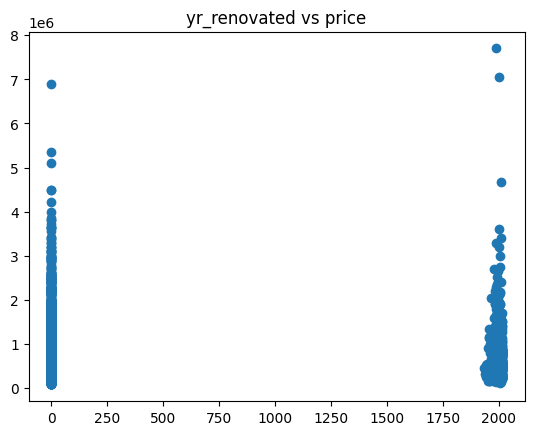

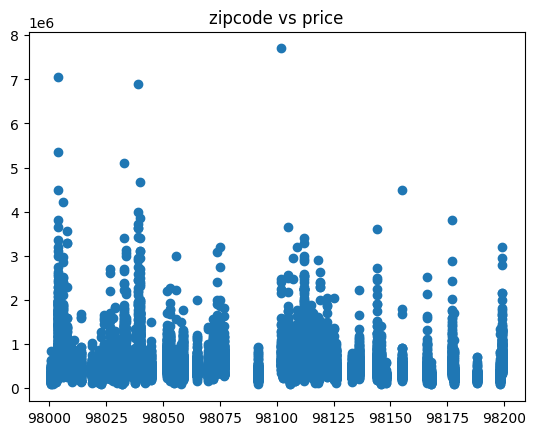

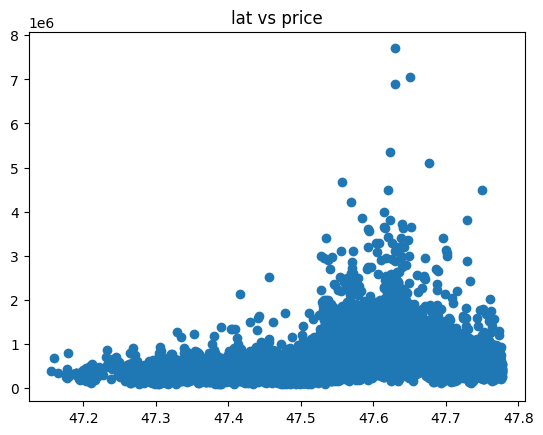

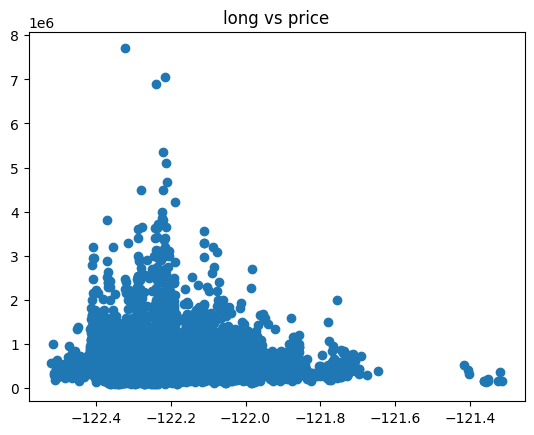

In [26]:
# Plotting scatter plots to ensure  that all continuous elements remaining in X_train are not 
# categorical data.

# defining variable columns with the continuous elements from the earlier function.

columns = list(X_train.columns)

y_col = "price"
x_columns = columns

# a for loop to loop through all the x_columns.
for x_col in x_columns:
    fig,ax = plt.subplots()
    ax.scatter(y = kc[y_col], x = kc[x_col])   
    ax.set_title(f"{x_col} vs {y_col}");

From the above scatter plots the following do not fit a linear relationship hence categorical data which will be added later.


 > lat<br>
 > long<br>
 > zipcode<br>
 > yr_renovated<br>
 > yr_built
 

In [27]:
# purifying the continuous dictionary
non_linear = {'lat','long','zipcode','yr_renovated','yr_built'}
X_train.drop(labels=non_linear,inplace=True,axis=1)
X_test.drop(labels = non_linear,axis=1,inplace=True)

In [28]:
# Double checking to ensure its purified.
X_train.head(5)

,sqft_living,sqft_lot
id,,
2780700020,1900,9428
1310800090,1470,7350
5130000090,2540,11562
1236300268,940,10360
424069096,1400,12155


In [29]:
# reassigning the X_train dataframe to X_multinear.

X_multilinear_1 = kc[list(X_train.columns)]

In [30]:
# using the Ordinary Least Method from stats model we can fit our model.

Multilinear_model_1 = sm.OLS(endog=y, exog=sm.add_constant(X_multilinear_1))
result_multilinear_1 = Multilinear_model_1.fit()

# Let us print out the summary for the model

print(result_multilinear_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     7872.
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:49:43   Log-Likelihood:            -2.1909e+05
No. Observations:               15762   AIC:                         4.382e+05
Df Residuals:                   15759   BIC:                         4.382e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.529e+04   5200.394    -10.631      

eval_env: 1
eval_env: 1


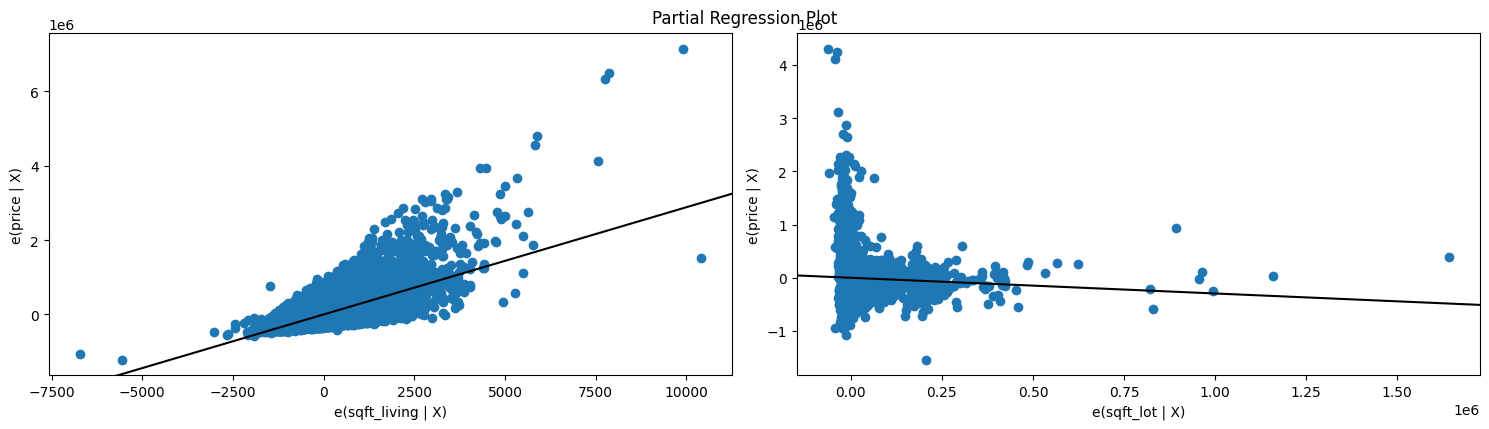

In [31]:
# making a partial regression plots based of the results.

fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    result_multilinear_1,
    exog_idx=list(X_multilinear_1.columns.values),
    grid=(2,2),
    fig=fig)
plt.show();

In [32]:
# Let us use the sklearn to calculate the mean absolute error.

y_pred = result_multilinear_1.predict(sm.add_constant(X_multilinear_1))

mean_absolute_error(y, y_pred)

174547.3468243376

Multilinear Model Intepretation.

* This means the multilinear model mean absolute error is about **175000 USD** meaning the predicted values will be of by about that much.

* Overall the model and coefficients are **statistically significant**, with all *p-values* well below a standard alpha of **0.05**.

* The Adj. R-squared value is about **0.500 i.e. 50%** of the variance in the target variable can be explained by sqft_living and sqft_lot. It is almost similar to the baseline model.

* The intercept is about **-5.529e+04 i.e.  -55,290 USD**, meaning that if one wanted a house with a square foot of living space of **0** and sqft_lot of **0** they would expect a price of about **-55160 USD**.but this can be ignored as a house with **0** sqft of living room cant exist outside the mathematical realm. 

* The sqft_living coefficient is about **290**, meaning that for each additional 1 USD on price of the house we have an additional square feet of living of about **290 sqft**.

* The sqft_above coefficient is about **-0.3**, meaning that for each additional 1 USD on price of the house we have an additional square footage of the house lot of about **-0.3 sqft** which is impractical in the realm of mathematics so they can be ignored, as no house can exist with a lot of 0.


## Mulitilinear Model 1      

**y = ([282 - 291])Sqft_living +([ -0.3 - -0.05])sqft_lot  + ([-65,400 - -45,000]) USD + 175,000 USD**

## Multilinear Regression with a categorical column.


let us randomly pick a category to add onto the multilinear regression.<br>
Houses with desired aesthetic views have a price premium over similar houses without such views so from this<br>

I pick the categorical variable views.

In [33]:
# checking out the value counts found in the category column 'view'

kc['view'].value_counts()

NONE         14241
AVERAGE        688
GOOD           348
FAIR           245
EXCELLENT      240
Name: view, dtype: int64

In [34]:
# Definig a new variable to hold the independent variables to use for the new model.

X_multilinear_2 = kc[['sqft_living','sqft_lot','view']]

In [35]:
# before i can use the new column views, i have to change it into a binary system.

X_multilinear_2 = pd.get_dummies(X_multilinear_2,columns=['view'])


In [36]:
X_multilinear_2.head()

,sqft_living,sqft_lot,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
id,,,,,,,
6414100192,2570,7242,0,0,0,0,1
2487200875,1960,5000,0,0,0,0,1
1954400510,1680,8080,0,0,0,0,1
7237550310,5420,101930,0,0,0,0,1
1321400060,1715,6819,0,0,0,0,1


In [37]:
# To avoid  multicoliniearity we have to drop one column.

# I will drop none as its the least priced category.

X_multilinear_2.drop(axis=1,inplace=True,columns=['view_NONE'])

In [38]:
# Preview of the dataframe.

X_multilinear_2.head()

,sqft_living,sqft_lot,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD
id,,,,,,
6414100192,2570,7242,0,0,0,0
2487200875,1960,5000,0,0,0,0
1954400510,1680,8080,0,0,0,0
7237550310,5420,101930,0,0,0,0
1321400060,1715,6819,0,0,0,0


In [39]:
# using the Ordinary Least Method from stats model we can fit our model.

Multilinear_model_2 = sm.OLS(endog=y, exog=sm.add_constant(X_multilinear_2))
result_multilinear_2 = Multilinear_model_2.fit()

# Let us print out the summary for the model

print(result_multilinear_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     3196.
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:50:09   Log-Likelihood:            -2.1827e+05
No. Observations:               15762   AIC:                         4.366e+05
Df Residuals:                   15755   BIC:                         4.366e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -2.58e+04   4994.742     -5.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


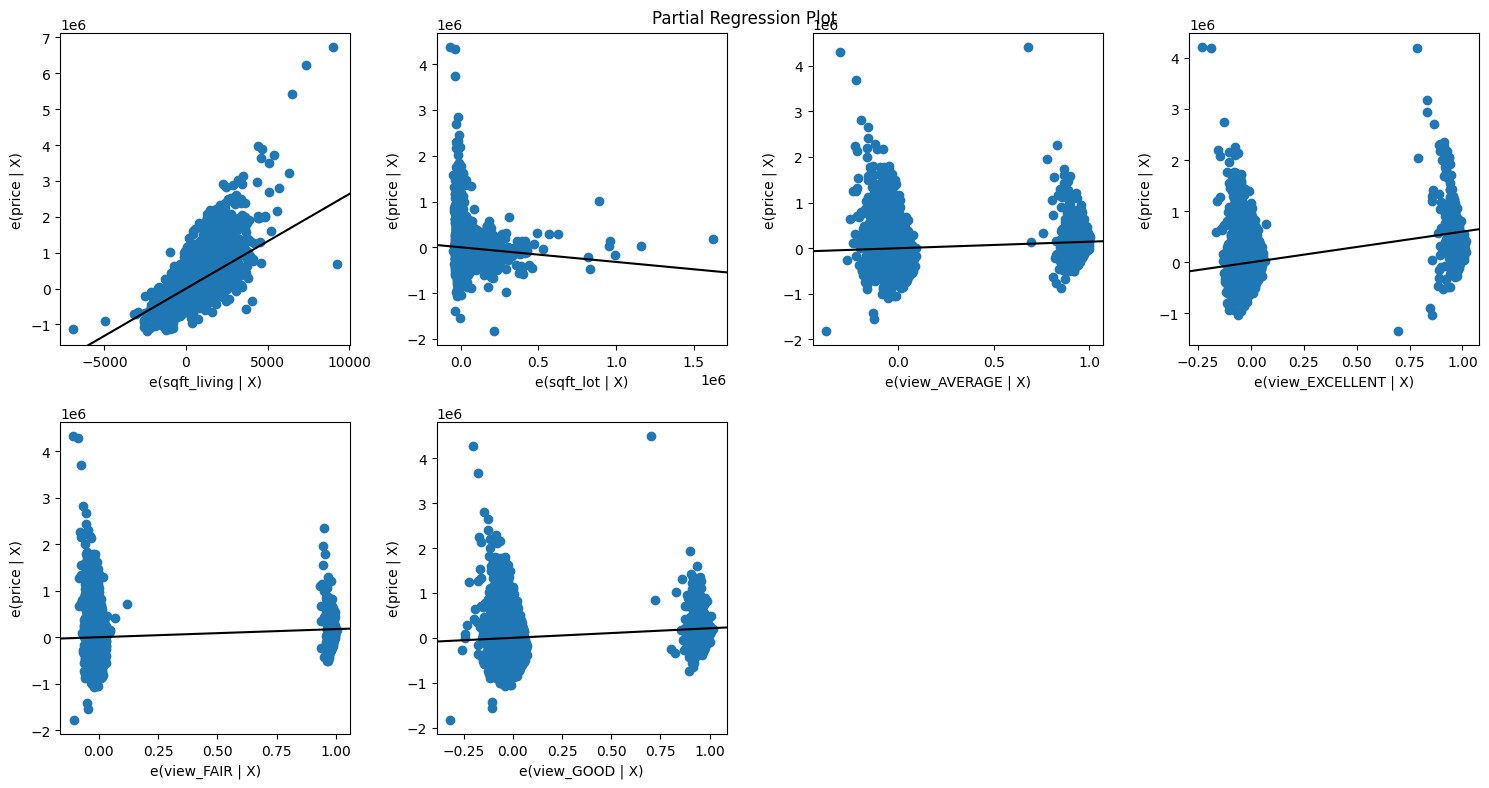

In [40]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    result_multilinear_2,
    exog_idx=list(X_multilinear_2.columns.values),
    grid=(2,4),
    fig=fig)
plt.show();

In [41]:
# Let us use the sklearn to calculate the mean absolute error.

y_pred = result_multilinear_2.predict(sm.add_constant(X_multilinear_2))

mean_absolute_error(y, y_pred)

167062.58219681965


Our model is statistically significant overall, and explains about **55%** of the
variance in Price. On average it is off by about **167,100 USD** in its predictions
of home price.

All of our coefficients are statistically significant

So we can say that:

> ***const***: When **sqft_living is 0**, **sqft_lot is 0**, and **view is none**, we would expect a home sale price    of ** -2.58e+04 USD i.e -25,800 USD**.

  
> ***sqft_living***: For each increase of **1 sqft** of living area, we see an associated increase of about **263 USD** in price.

  
> ***sqft_lot***: For each increase of **1 in sqft** of the lot, we see an associated
 decrease of about **-0.32 USD** in  price. 
   
> ***view_AVERAGE***: Compared to None, meaning no view, we see an associated
increase of about **1.432e+05 i.e 143,200 USD** for an average view
   
> ***view_FAIR***: Compared to a None, no view , we see an associated
increase of about **1.749e+05 i.e 174,900 USD** for a fair view.

   
> ***view_GOOD***: Compared to no view (None_View), we see an associated
increase of about **2.124e+05 i.e 212,400 USD** for a good view.

   
> ***view_EXCELLENT***: Compared to no view (None_View), we see an associated
increase of about **6.009e+05 i.e  600,900 USD** for an excellent view.



Looking at the partial regression plots, the dummy variables look fairly
different from the other variables. They tend to have two clusters rather than
a continuous "cloud".


## Multilinear Regression with another more  categorical column.

Apart from view i would like to try a multilinear model with the condition category.<br>

The condition the house is in will have a major bearing on the price it could potentially sell for.<br>

and since having more than two categories may lead to more errors i will not mix it with views.

In [42]:
kc['condition'].value_counts()

Average      10221
Good          4137
Very Good     1254
Fair           131
Poor            19
Name: condition, dtype: int64

In [43]:
# Definig a new variable to hold the independent variables to use for the new model.

X_multilinear_3 = kc[['sqft_living','sqft_lot','condition']]

In [44]:
# before i can use the new column views, i have to change it into a binary system.

X_multilinear_3 = pd.get_dummies(X_multilinear_3,columns=['condition'])

In [45]:
# Preview of the dataframe.

X_multilinear_3.head()

,sqft_living,sqft_lot,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_Very Good
id,,,,,,,
6414100192,2570,7242,1,0,0,0,0
2487200875,1960,5000,0,0,0,0,1
1954400510,1680,8080,1,0,0,0,0
7237550310,5420,101930,1,0,0,0,0
1321400060,1715,6819,1,0,0,0,0


In [46]:
# To avoid  multicoliniearity we have to drop one column.

# I will drop condition_Average as its the worst priced category.

X_multilinear_3.drop(axis=1,inplace=True,columns=['condition_Average'])

In [47]:
# using the Ordinary Least Method from stats model we can fit our model.

Multilinear_model_3 = sm.OLS(endog=y, exog=sm.add_constant(X_multilinear_3))
result_multilinear_3 = Multilinear_model_3.fit()

# Let us print out the summary for the model

print(result_multilinear_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     2697.
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:50:24   Log-Likelihood:            -2.1898e+05
No. Observations:               15762   AIC:                         4.380e+05
Df Residuals:                   15755   BIC:                         4.380e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.839e+04   5

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


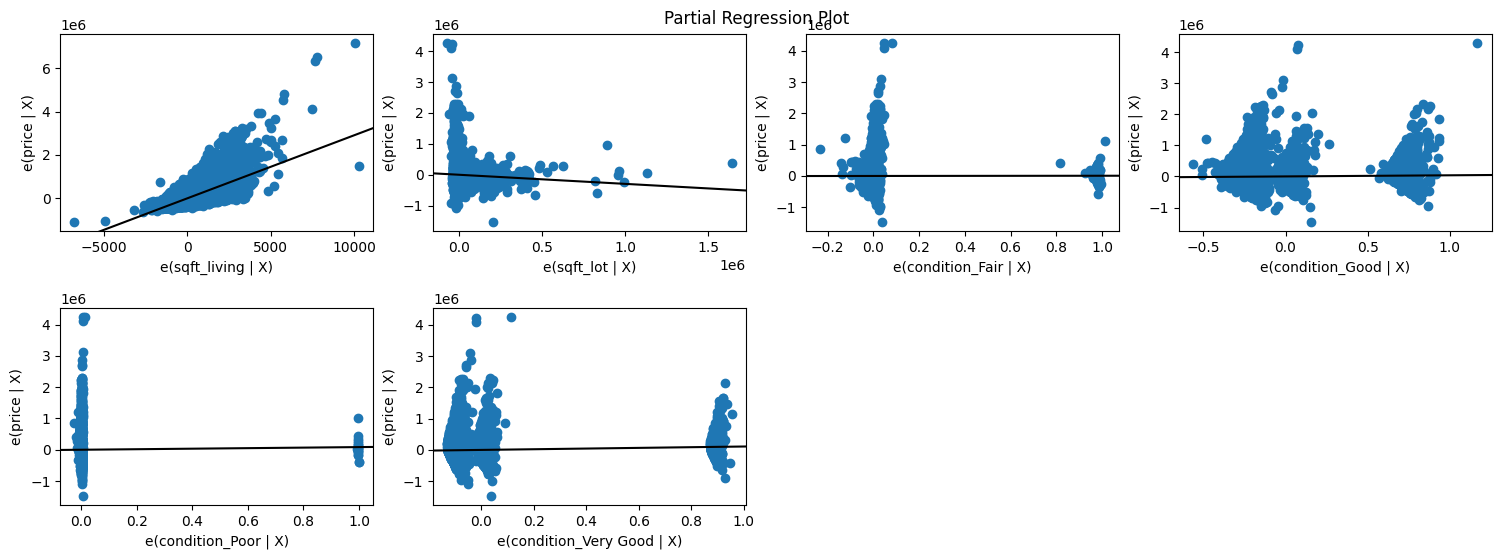

In [48]:
fig = plt.figure(figsize=(15,8))
sm.graphics.plot_partregress_grid(
    result_multilinear_3,
    exog_idx=list(X_multilinear_3.columns.values),
    grid=(3,4),
    fig=fig)
plt.show();

In [49]:
# Let us use the sklearn to calculate the mean absolute error.

y_pred = result_multilinear_3.predict(sm.add_constant(X_multilinear_3))

mean_absolute_error(y, y_pred)

173655.8755334509

Our model is statistically significant overall, and explains about **51%** of the
variance in Price. On average it is off by about **174,000 USD** in its predictions
of home price.

All of our coefficients are statistically significant apart from condition fair and conndition poor.

So we can say that:

> ***const***: When **sqft_living is 0**, **sqft_lot is 0**, and **condition is average**, we would expect a home sale price    of **-7.839e+04 USD i.e  -78,400 USD**.which can be ignored.

  
> ***sqft_living***: For each increase of **1 sqft** of living area, we see an associated increase of about **290 USD** in price.

  
> ***sqft_lot***: For each increase of **1 in sqft** of the lot, we see an associated
 decrease of about **-0.3 USD** in  price. 
   
> ***condition_Good***: Compared to average condition, we see an associated
increase of about **3.625e+04  i.e 36,250 USD**.

   
> ***condition_Very Good***: Compared to a None, no view , we see an associated
increase of about **1.09e+05 i.e 109,000 USD**.

   




Looking at the partial regression plots, the dummy variables look fairly
different from the other variables. They tend to have two clusters rather than
a continuous "cloud".


# RESULTS

#### Baseline Model

**y = (290)Sqft_living -55,160 USD + 175,000 USD**

This is the formular to predict the price, but it only explains about 50% of the variance in price.
Taking into consideration the 95% confidence for the coefficients;
> constant = [-65,400  -  -45,000]<br>
> slope = [282   -  291]

**y = ([282 - 291])Sqft_living + ([-65,400 - -45,000]) USD + 175,000 USD**



#### Multilinear Models

From the two multilinear models made above;
> sqft_lot
> views
> conditions

I will favour the views as all its coefficients are statistically significant in comparison to conditions. And it explains about 60% of the varaince in price in comparison to sqft_lot and sqft_living alone.

From the views multimedia regresion model, The predictive formula is given by;

**y = (263)Sqft_living - (0.32)Sqft_lot + (143,200)view_Average + (174,900)view_Fair + (212,400)view_Good +
      (600,900)view_Excellent - 25,800 USD + 167,100 USD**
      
Taking into consideration the 95% confidence for the coefficients;

  > constant = [-35,600 - -16,000]
  > slope_sqft_living = [259 - 268]
  > slope_sqft_lot = [-0.41 - -0.23]
  > slope_view_AVERAGE = [143,200 - 9,880]
  > slope_view_Fair = [174,900 - 16,200]
  > slope_view_Good = [212,400 - 13,800]
  > slope_view_Excellent = [600,900   16,600]
  

**y = ([259 - 268])Sqft_living - ([-0.41 - -0.23])Sqft_lot + ([143,200 - 9,880])view_Average + ([174,900 - 16,200])view_Fair + ([212,400 - 13,800])view_Good + ([600,900   16,600])view_Excellent - 25,800 USD + 167,100 USD**
      


# CONCLUSION

I think the accuracy of the predictive formular would be more accurate if the data was grouped by the zipcode as the variance comes from mixing zipcodes of low costing houses with zipcodes with high priced areas, with zipcode specificity the accuray i believe would be greatly increased instead of just relying on county. I got this observation by using tableau.